## Notebook 5: Data loaders

In [1]:
# Imports
import os
import numpy as np
import pandas as pd
import cv2

# Matplotlib for plotting
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm

# PyTorch methods
from torch.utils.data import DataLoader

# Albumentations library
import albumentations as alb

# Appearance of the Notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(linewidth=110)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Import this module with autoreload
%load_ext autoreload
%autoreload 2
import dentexmodel as dm
from dentexmodel.imageproc import ImageData
from dentexmodel.torchdataset import DatasetFromDF, load_and_process_image

print(f'Project module version: {dm.__version__}')

Project module version: 0.0.post1.dev25+ga99b50c.d20231228


In [2]:
# Path settings 
dentex_dir = os.path.join(os.environ['HOME'], 'data', 'dentex')
data_dir = os.path.join(dentex_dir, 'dentex_disease')
image_dir = os.path.join(data_dir, 'quadrant-enumeration-disease', 'xrays', 'crop')
data_file_name = 'dentex_disease_datasplit.parquet'
data_file = os.path.join(dentex_dir, data_file_name)

### Create PyTorch dataset from data frame ###

In [3]:
data_df = pd.read_parquet(data_file)
# Convert class names to labels
cl_names = sorted(list(data_df['label'].unique()))
# Let's assign number to the classes
label_dict = dict(zip(cl_names, range(len(cl_names))))
cl_dict = dict(zip(label_dict.values(), label_dict.keys()))

# Add the class labels to the data frame
seed = np.random.seed(123)
data_df = data_df.\
                assign(cl=data_df['label'].apply(lambda l: label_dict.get(l))).\
                sample(frac=1, random_state=seed).\
                reset_index(drop=True)

# Show the class labels
display(pd.DataFrame(label_dict, index=[0]).iloc[0])

Caries               0
Deep Caries          1
Impacted             2
Periapical Lesion    3
Name: 0, dtype: int64

In [4]:
# Class label definitions
display(label_dict)
# Maximum image size
max_im_width = data_df['im_width'].max()
max_im_height = data_df['im_height'].max()

print(f'Maximum image height across the data set: {max_im_height}')
print(f'Maximum image width across the data set:  {max_im_width}')

# The maximum dimension is the max_im_height:
max_image_size = np.max([max_im_height, max_im_width])

{'Caries': 0, 'Deep Caries': 1, 'Impacted': 2, 'Periapical Lesion': 3}

Maximum image height across the data set: 539
Maximum image width across the data set:  363


### PyTorch dataset from data frame ###
Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code to be decoupled from our model training code for better readability and modularity. PyTorch provides two data primitives: torch.utils.data.DataLoader and torch.utils.data.Dataset that allow you to use pre-loaded datasets as well as your own data. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [5]:
# Image augmentations is part of the PyTorch dataset

# The output of this transformation must match the required input size for the model
im_size = 512

# Definition of the image augmentations for the training set
train_transform = alb.Compose([
    alb.Resize(im_size + 32, im_size + 32),
    alb.RandomCrop(im_size, im_size),
    alb.HorizontalFlip(),
    alb.ShiftScaleRotate(),
    alb.Blur(),
    alb.RandomGamma(),
    alb.Sharpen(),
    alb.GaussNoise(),
    alb.CoarseDropout(16, 32, 32),
    alb.CLAHE(),
    alb.Normalize(mean=0, std=1)])

# Vor validation and testing, we do not want any augmentations
# but we will still need the correct input size and image normalization
val_transform = alb.Compose([
    alb.Resize(im_size, im_size),
    alb.Normalize(mean=0, std=1)])

In [6]:
# Select the training samples from our data frame
train_df = data_df.loc[data_df['dataset']=='train']
val_df = data_df.loc[data_df['dataset']=='val']
test_df = data_df.loc[data_df['dataset']=='test']

train_samples = sorted(list(train_df['box_name'].unique()))
print(f'Found {len(train_samples)} samples in the training set.')
val_samples = sorted(list(val_df['box_name'].unique()))
print(f'Found {len(val_samples)} samples in the validation set.')
test_samples = sorted(list(test_df['box_name'].unique()))
print(f'Found {len(test_samples)} samples in the test set.')
print()
display(test_df.head(2))

Found 3349 samples in the training set.
Found 60 samples in the validation set.
Found 120 samples in the test set.



,height,width,id,file_name,image_number,file_path,quadrant,position,label,area,bbox,box_name,annotations,box_file,im_width,im_height,dataset,cl
7,1316,2862,410,train_59.png,59,/app/data/dentex/dentex_disease/quadrant-enume...,3,6,Periapical Lesion,50805,"[1740.0, 648.0, 252.0, 332.0]",train_59_2154_3_6,6,/app/data/dentex/dentex_disease/quadrant-enume...,252,332,test,3
12,1316,2910,11,train_498.png,498,/app/data/dentex/dentex_disease/quadrant-enume...,1,8,Impacted,20726,"[869.0, 424.0, 222.0, 184.0]",train_498_68_1_8,12,/app/data/dentex/dentex_disease/quadrant-enume...,222,184,test,2


In [7]:
display(train_df['label'].value_counts())

# Create the data sets from the data frame
train_dataset = DatasetFromDF(data=train_df,
                              file_col='box_file',
                              label_col='cl',
                              max_image_size=max_image_size,
                              transform=train_transform,
                              validate=True)

val_dataset = DatasetFromDF(data=val_df,
                            file_col='box_file',
                            label_col='cl',
                            max_image_size=max_image_size,
                            transform=val_transform,
                            validate=True)

test_dataset = DatasetFromDF(data=test_df,
                             file_col='box_file',
                             label_col='cl',
                             max_image_size=max_image_size,
                             transform=val_transform,
                             validate=True)

label
Caries               2144
Impacted              559
Deep Caries           533
Periapical Lesion     113
Name: count, dtype: int64

### Retrieve one image from the data set ###
Everytime the cell is run, a difference augmentation is generated from the same image

In [8]:
def image_stats(ig, decimals=3):

    """ Returns pandas series with image stats """
    
    output_dict = {'im_width': ig.shape[1],
                   'im_height': ig.shape[0],
                   'im_min': np.round(np.min(ig), decimals=decimals),
                   'im_max': np.round(np.max(ig), decimals=decimals),
                   'im_mean': np.round(np.mean(ig), decimals=decimals),
                   'im_std': np.round(np.std(ig), decimals=decimals)}
                   
    return pd.DataFrame(output_dict, index=[0]).iloc[0]

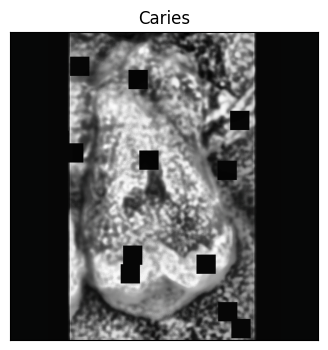

im_width     512.000
im_height    512.000
im_min         0.000
im_max         1.000
im_mean        0.296
im_std         0.291
Name: 0, dtype: float64

In [9]:
# Retrieve one (image, label) sample from the data set
image_index = 234
image_sample, label_sample = train_dataset[image_index]
# We need to move the color channel back to the end of the array
image = np.transpose(image_sample.numpy(), (1, 2, 0))
label = cl_dict.get(int(label_sample.numpy()))
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(image)
ax.set(xticks=[], yticks=[], title=str(label))
plt.show()
print()
display(image_stats(image))

### PyTorch DataLoader ###
In PyTorch, a DataLoader is part of the torch.utils.data module which is used for loading datasets in a systematic and organized way.
The data loader takes in a dataset and transforms it into batches so that the data can be processed more efficiently.

In [10]:
dataloader = DataLoader(dataset=train_dataset, batch_size=16)

# The dataloader can be converted into an iterator which returns images and labels
image_batch, label_batch = next(iter(dataloader))

print(f'Size of the image batch: {image_batch.numpy().shape}')
print(f'Labels:                  {label_batch.numpy()}')

Size of the image batch: (16, 3, 512, 512)
Labels:                  [0 0 2 1 0 1 0 0 0 2 0 1 0 0 1 2]


### DataLoader from the lightning model class ###

torch.Size([4, 3, 512, 512])
torch.Size([4])


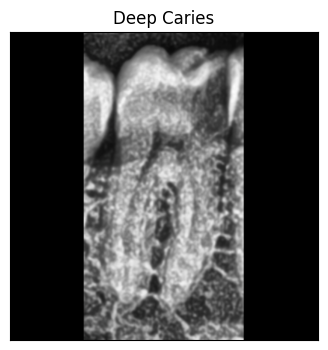

In [11]:
from dentexmodel.models.toothmodel import ToothModel

model = ToothModel(train_dataset=train_dataset,
                   val_dataset=val_dataset,
                   test_dataset=test_dataset,
                   batch_size=4,
                   num_workers=0)

dl = model.val_dataloader()
image_batch, label_batch = next(iter(dl))

print(image_batch.shape)
print(label_batch.shape)

# Plot one image from the batch with label
image_idx = 0
image = np.transpose(image_batch.numpy()[image_idx], axes=(1, 2, 0))
label = cl_dict.get(label_batch.numpy()[image_idx])
fig, ax = plt.subplots(figsize=(4,4))
ax.imshow(image, cmap='gray')
ax.set_title(label)
ax.set(xticks=[], yticks=[])
plt.show()